In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from datetime import timedelta

ModuleNotFoundError: No module named 'pandas'

In [0]:
# tabela :: wget -r https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv
dates = pd.read_csv("/content/cases-brazil-states.csv",header=0,index_col="date")

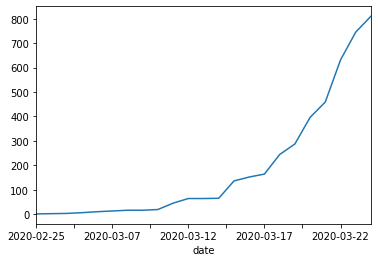

In [6]:
estado = dates[dates["state"]=="SP"]
# for i in enumerate(timebr):
#   timebr[timebr.index.values[i[0]]] = datetime.strptime(i[1], "%Y-%m-%d %H:%M:%S.%f")
estado.totalCases.plot()

In [19]:
case1 = pd.to_datetime(estado.index[np.where(estado["totalCases"] > 0)][0])
(pd.to_datetime(estado.index[3])-case1).days)

int

In [0]:
# modifica os dados para utilizar no curve fit
xtimebr=[]
ydatabr=[]
dia=[]
today=datetime.now().date()
estado.index = pd.to_datetime(estado.index)
case1 = estado.index[np.where(estado["totalCases"] > 0)][0]
# print(today)
for ib in enumerate(estado.index):
  # somente dias onde o numero de casos confirmados é maior que 0
  # para o Brasil
  if estado["totalCases"][estado.index[ib[0]]] >0:
    # procura os dias..
    # print(ib[1])
    selday = ((ib[1])-case1).days == np.arange(0,32,1)
    # a cada dois dias pegamos o numero de casos e convete o dia para dia inteiro
    # dia negativo está no passado.. -2 ==dois dias antes do atual var(today)
    if True in selday:
      xtimebr.append((ib[1]-case1).days)
      ydatabr.append(estado["totalCases"][estado.index[ib[0]]])
      dia.append(estado.index[ib[0]])

# dados selecionador para fazer o ajsute
ydatabr  = np.array(ydatabr)
xdatabr = np.array(xtimebr)
for i in range(5):
  dia.append(dia[-1]+timedelta(days=1))

In [22]:
dia

[Timestamp('2020-02-25 00:00:00'),
 Timestamp('2020-02-29 00:00:00'),
 Timestamp('2020-03-04 00:00:00'),
 Timestamp('2020-03-05 00:00:00'),
 Timestamp('2020-03-06 00:00:00'),
 Timestamp('2020-03-07 00:00:00'),
 Timestamp('2020-03-08 00:00:00'),
 Timestamp('2020-03-09 00:00:00'),
 Timestamp('2020-03-10 00:00:00'),
 Timestamp('2020-03-11 00:00:00'),
 Timestamp('2020-03-12 00:00:00'),
 Timestamp('2020-03-13 00:00:00'),
 Timestamp('2020-03-14 00:00:00'),
 Timestamp('2020-03-15 00:00:00'),
 Timestamp('2020-03-16 00:00:00'),
 Timestamp('2020-03-17 00:00:00'),
 Timestamp('2020-03-18 00:00:00'),
 Timestamp('2020-03-19 00:00:00'),
 Timestamp('2020-03-20 00:00:00'),
 Timestamp('2020-03-21 00:00:00'),
 Timestamp('2020-03-22 00:00:00'),
 Timestamp('2020-03-23 00:00:00'),
 Timestamp('2020-03-24 00:00:00'),
 Timestamp('2020-03-25 00:00:00'),
 Timestamp('2020-03-26 00:00:00'),
 Timestamp('2020-03-27 00:00:00'),
 Timestamp('2020-03-28 00:00:00'),
 Timestamp('2020-03-29 00:00:00')]

In [0]:
# ajuste exponencial com a func, dos dasos xdata e ydata Brasil
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(b * x) + c

# Brasil
poptbr, pcovbr = curve_fit(func, xdatabr, ydatabr)
perrbr = np.sqrt(np.diag(pcovbr))
poptbr

### model SIR
https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

In [0]:
from scipy.integrate import odeint

# Total population, N. 
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
nday = 4.0
beta, gamma = 0.2, 1./nday 
# A grid of time points (in days)
t = np.linspace(0, 160, 1600)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

Model SIER
https://github.com/XuelongSun/Dynamic-Model-of-Infectious-Diseases/blob/master/SIR.ipynb

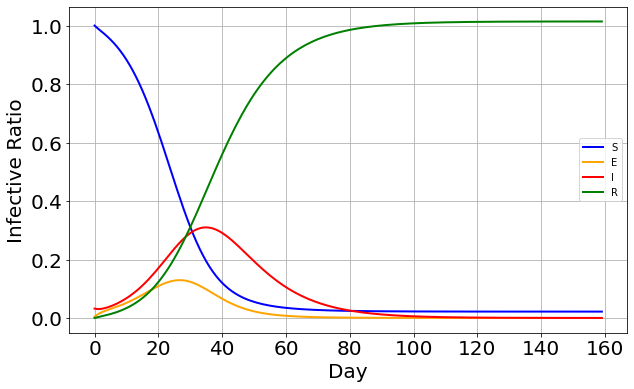

In [0]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(s, c='b', lw=2, label='S')
ax.plot(e, c='orange', lw=2, label='E')
ax.plot(i, c='r', lw=2, label='I')
ax.plot(r, c='g', lw=2, label='R')
ax.set_xlabel('Day',fontsize=20)
ax.set_ylabel('Infective Ratio', fontsize=20)
ax.grid(1)
ax.set_xlim(0,50)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend();

In [0]:
# population
N = 1e3
# simuation Time / Day
T = 160
tm = np.linspace(0, T, T)
# susceptiable ratio
s = np.zeros([T])
# exposed ratio
e = np.zeros([T])
# infective ratio
i = np.zeros([T])
# remove ratio
r = np.zeros([T])

# contact rate
lamda = 0.3
# recover rate
gamma = 0.0821
# exposed period
sigma = 1 / 4

# initial infective people
i[0] = 32.0 / N
s[0] = N / N
e[0] = 4.0 / N
for t in range(T-1):
    s[t + 1] = s[t] - lamda * s[t] * i[t]
    e[t + 1] = e[t] + lamda * s[t] * i[t] - sigma * e[t]
    i[t + 1] = i[t] + sigma * e[t] - gamma * i[t]
    r[t + 1] = r[t] + gamma * i[t]